In [1]:
from keras.layers import Dropout, Dense, Flatten, Activation, Input, Embedding, Dot, Concatenate, Multiply
from keras.models import Model
from sklearn.model_selection import train_test_split

from pylab import rcParams

import matplotlib.pyplot as plt
import pandas as pd


In [2]:
ratings_df = pd.read_csv('./data/movies/ratings.csv').drop('timestamp', axis=1)
movies_df = pd.read_csv('./data/movies/movies.csv')

In [3]:
ratings_df.head()

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


In [4]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
users = ratings_df.userId.unique()
movies = ratings_df.movieId.unique()

In [4]:
userid2idx = {o: i for i, o in enumerate(users)}
movieid2idx = {o: i for i, o in enumerate(movies)}
df = ratings_df.copy(deep=True)
df['userId'] = df['userId'].apply(lambda x: userid2idx[x])
df['movieId'] = df['movieId'].apply(lambda x: movieid2idx[x])

In [5]:
df[['userId', 'movieId']]

,userId,movieId
0,0,0
1,0,1
2,0,2
3,0,3
4,0,4
...,...,...
99999,670,7005
100000,670,4771
100001,670,1329
100002,670,1331


In [7]:
train, valid = train_test_split(df, test_size=0.2)
train, test = train_test_split(train, test_size=0.2)

In [9]:
n_latent_factors = 50

In [8]:
from keras import ops


def rmse(y_true, y_pred):
    squared_difference = ops.square(y_true - y_pred)
    return ops.sqrt(ops.mean(squared_difference, axis=-1))  # Note the `axis=-1`

In [11]:
n_movies = len(df['movieId'].unique())
n_users = len(df['userId'].unique())

Model 1: just embeddings

In [12]:
user_input = Input(shape=(1,), dtype='int64')
user_embedding = Embedding(n_users, n_latent_factors)(user_input)
user_vec = Flatten(name='FlattenUsers')(user_embedding)

movie_input = Input(shape=(1,), dtype='int64')
movie_embedding = Embedding(n_movies, n_latent_factors)(movie_input)
movie_vec = Flatten(name='FlattenMovies')(movie_embedding)

sim = Dot(axes=1)([user_vec, movie_vec])
emb_model = Model([user_input, movie_input], sim)
emb_model.compile(loss=rmse)

In [13]:
emb_history = emb_model.fit([train.userId, train.movieId], train.rating,
                            validation_data=([valid.userId, valid.movieId], valid.rating),
                            batch_size=64, epochs=15, verbose=1)

Epoch 1/15
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 3.5472 - val_loss: 3.5189
Epoch 2/15
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 3.4642 - val_loss: 2.9840
Epoch 3/15
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 2.7035 - val_loss: 2.1068
Epoch 4/15
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 1.9288 - val_loss: 1.6440
Epoch 5/15
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 1.5007 - val_loss: 1.3745
Epoch 6/15
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 1.2529 - val_loss: 1.2190
Epoch 7/15
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 1.0998 - val_loss: 1.1240
Epoch 8/15
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 0.9981 - val_loss: 1.0592
Epoch 9/15
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.9251 - val_loss: 1.0161
Epoch 10/15
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.8706 - val_loss: 0.9825
Epoch 11/15
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.8245 - val_loss: 0.9579
Epoch 12/15
1001/1001 ━━━━━━

In [14]:
emb_model.evaluate(
    x=(test.userId, test.movieId),
    y=test.rating,
)

501/501 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.8925


0.8876381516456604

In [42]:
def plot_loss(_history, saving_path: str = None):
    rcParams['figure.figsize'] = 10, 5
    plt.plot(_history.history['loss'], 'g')
    plt.plot(_history.history['val_loss'], 'b')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.grid(True)

    if saving_path is not None:
        plt.savefig(saving_path)

    plt.show()


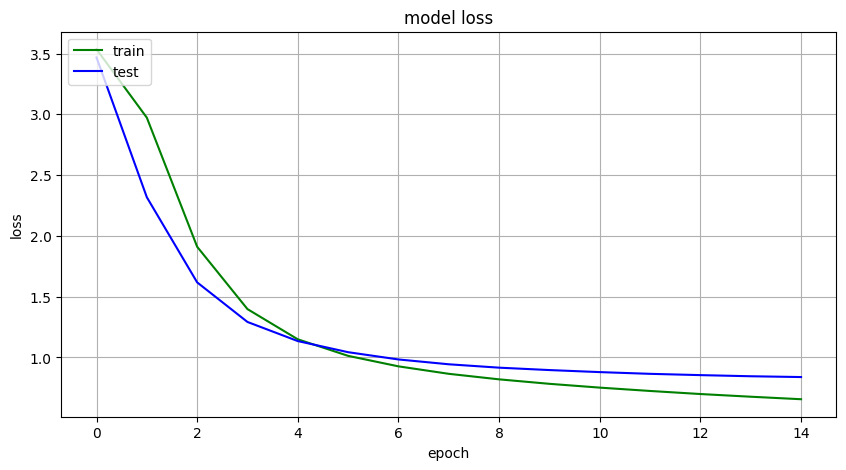

In [205]:
plot_loss(emb_history)

Model 2: NN filtration

In [15]:
user_input = Input(shape=(1,), dtype='int64')
user_embedding = Embedding(n_users, n_latent_factors)(user_input)
user_vec = Flatten()(user_embedding)
user_vec = Dropout(0.8)(user_vec)

movie_input = Input(shape=(1,), dtype='int64')
movie_embedding = Embedding(n_movies, n_latent_factors)(movie_input)
movie_vec = Flatten()(movie_embedding)
movie_vec = Dropout(0.8)(movie_vec)

sim = Multiply()([user_vec, movie_vec])

nn_inp = Dense(200, activation='relu')(sim)
nn_inp = Dropout(0.5)(nn_inp)

nn_inp = Dense(1, activation='relu')(nn_inp)

nn_model = Model([user_input, movie_input], nn_inp)
nn_model.compile(loss=rmse)

In [16]:
nn_history = nn_model.fit([train.userId, train.movieId], train.rating,
                          validation_data=([valid.userId, valid.movieId], valid.rating),
                          batch_size=128, epochs=15, verbose=1)

Epoch 1/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 1.8114 - val_loss: 0.8543
Epoch 2/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.8783 - val_loss: 0.8541
Epoch 3/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.8753 - val_loss: 0.8557
Epoch 4/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.8731 - val_loss: 0.8539
Epoch 5/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.8714 - val_loss: 0.8593
Epoch 6/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.8694 - val_loss: 0.8527
Epoch 7/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.8657 - val_loss: 0.8523
Epoch 8/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.8667 - val_loss: 0.8546
Epoch 9/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.8628 - val_loss: 0.8559
Epoch 10/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.8597 - val_loss: 0.8503
Epoch 11/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.8595 - val_loss: 0.8520
Epoch 12/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step

In [17]:
nn_model.evaluate(
    x=(test.userId, test.movieId),
    y=test.rating,
)

501/501 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8394


0.8367028832435608

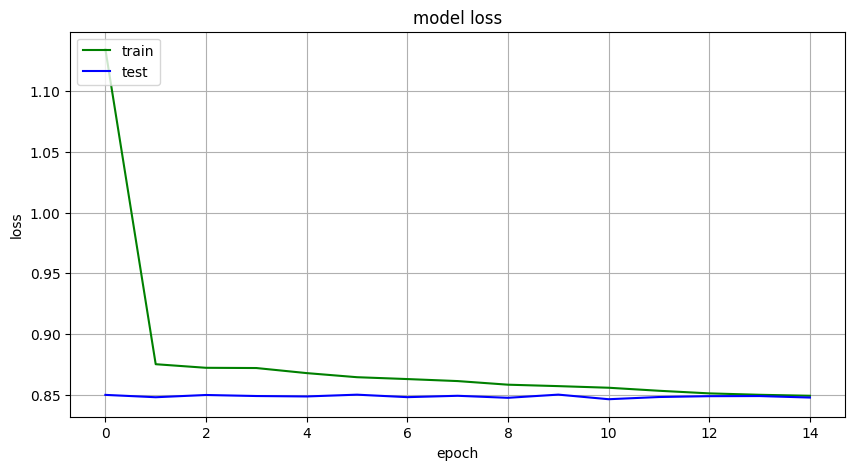

In [208]:
plot_loss(nn_history)

Model 3: ensemble 

In [18]:
user_input = Input(shape=(1,), dtype='int64')
user_embedding = Embedding(n_users, n_latent_factors)(user_input)
user_vec = Flatten()(user_embedding)

movie_input = Input(shape=(1,), dtype='int64')
movie_embedding = Embedding(n_movies, n_latent_factors)(movie_input)
movie_vec = Flatten()(movie_embedding)

user_drop = Dropout(0.9)(user_vec)
movie_drop = Dropout(0.9)(movie_vec)

emd_sim = Dot(axes=1)([user_vec, movie_vec])
nn_sim = Dot(axes=1)([user_drop, movie_drop])

concated = Concatenate()([emd_sim, nn_sim])
dense1 = Dense(200, activation='relu')(concated)
drop1 = Dropout(0.9)(dense1)
dense2 = Dense(96, activation='relu')(drop1)
drop2 = Dropout(0.8)(dense2)
dense3 = Dense(1, activation='relu')(drop2)

ens_model = Model([user_input, movie_input], dense2)
ens_model.compile(loss=rmse)

In [19]:
ens_history = ens_model.fit([train.userId, train.movieId], train.rating,
                          validation_data=([valid.userId, valid.movieId], valid.rating),
                          batch_size=512, epochs=15, verbose=1)

Epoch 1/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 3.2288 - val_loss: 1.2449
Epoch 2/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.2683 - val_loss: 0.8804
Epoch 3/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1.0948 - val_loss: 0.8609
Epoch 4/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.0582 - val_loss: 0.8568
Epoch 5/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.0359 - val_loss: 0.8650
Epoch 6/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.0286 - val_loss: 0.8567
Epoch 7/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0140 - val_loss: 0.8613
Epoch 8/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.9967 - val_loss: 0.8697
Epoch 9/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.9872 - val_loss: 0.8597
Epoch 10/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.9811 - val_loss: 0.8562
Epoch 11/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.9672 - val_loss: 0.8543
Epoch 12/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 1

In [20]:
ens_model.evaluate(
    x=(test.userId, test.movieId),
    y=test.rating,
)

501/501 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7883


0.7886475920677185

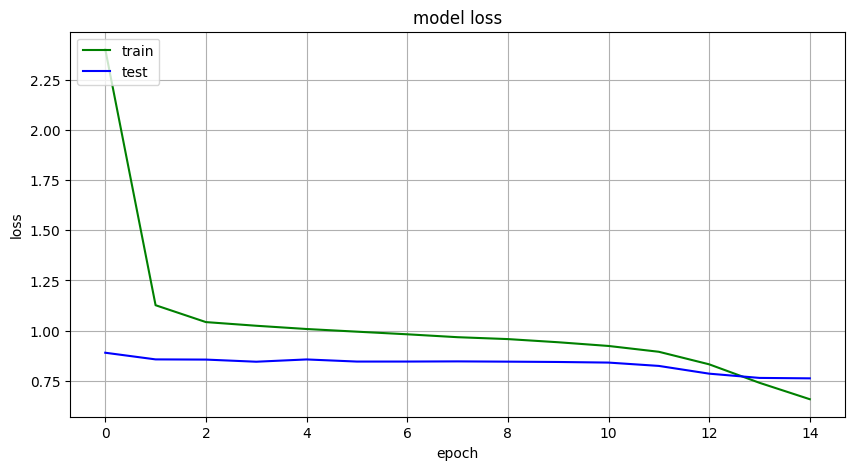

In [46]:
plot_loss(ens_history, saving_path='./checkpoints/plots/ensemble_15_loss.png')